# Using KMeans Clustering for Local Linear Regression

Based on the paper [Comparative study on fuzzy inference systems for prediction of concrete compressive strength](https://downloads.hindawi.com/journals/tswj/2014/381549.pdf). Host site [here](https://www.hindawi.com/journals/tswj/2014/381549/)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline


In [3]:
df = pd.read_csv('Concrete_Data.csv')
feature_names = ['cement', 'slag', 'fly_ash', 'water', 'superplasticizer', 'ca', 'fa', 'age']
label_names = ['ccs']
df = df.rename(columns={k: v for k, v in zip(df.columns, feature_names + label_names)})

def split_features_labels(df):
  features = df[feature_names]
  labels = df['ccs']
  return features, labels

features, labels = split_features_labels(df)

In [ ]:
df

,cement,slag,fly_ash,water,superplasticizer,ca,fa,age,ccs
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.284354
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.178794
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.696601
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.768036


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f512aed3fd0>,
      dtype=object)

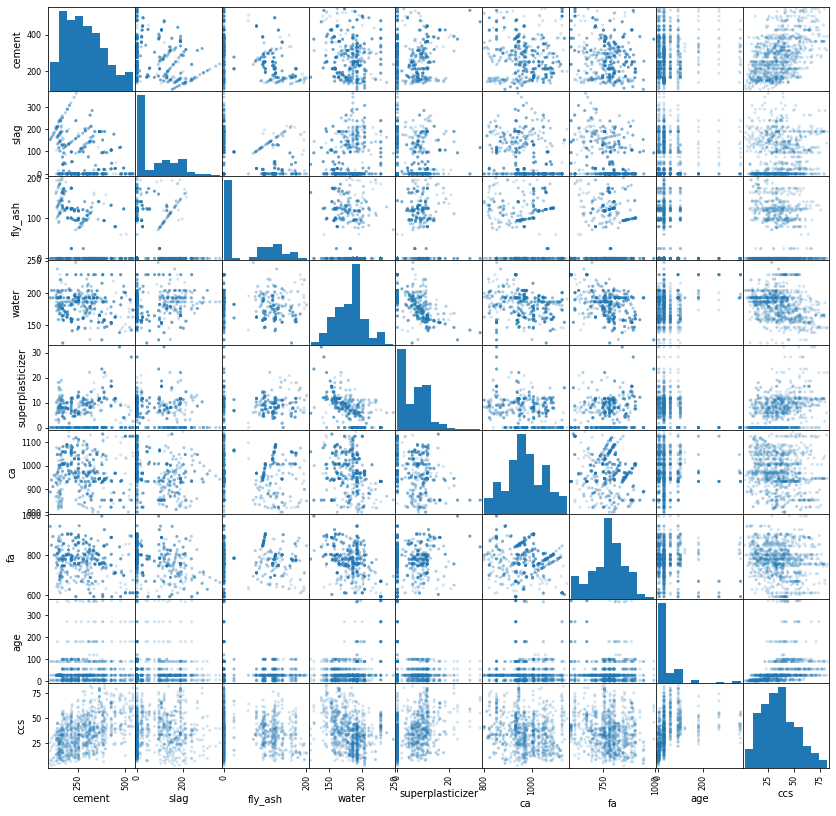

In [4]:
pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(14, 14))

In [5]:
# Apply local prediction by first partitioning all data points via KMeans clustering & CMeans clustering, then fit a regression

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def run_local_regression(X_train, X_test, y_train, y_test):
  lin_reg = LinearRegression().fit(X_train, y_train)
  y_pred_lin = lin_reg.predict(X_test)
  lin_reg_score = lin_reg.score(X_test, y_test)
  mae_lin_reg = mean_absolute_error(y_test, y_pred_lin)
  rmse_lin_reg = mean_squared_error(y_test, y_pred_lin, squared=False)
  mape_lin_reg = mean_absolute_percentage_error(y_test, y_pred_lin)

  lasso_reg = Lasso().fit(X_train, y_train)
  y_pred_lasso = lasso_reg.predict(X_test)
  lasso_reg_score = lasso_reg.score(X_test, y_test)
  mae_lasso_reg = mean_absolute_error(y_test, y_pred_lasso)
  rmse_lasso_reg = mean_squared_error(y_test, y_pred_lasso, squared=False)
  mape_lasso_reg = mean_absolute_percentage_error(y_test, y_pred_lasso)

  return lin_reg_score, mae_lin_reg, rmse_lin_reg, mape_lin_reg, lasso_reg_score, mae_lasso_reg, rmse_lasso_reg, mape_lasso_reg

def regression_on_locals_scores(random_state, scale=False, display_individuals=False):
  X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=random_state, train_size=0.8)

  if scale:
    scaler = StandardScaler().fit(X_train)
    X_col_names = X_train.columns
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X_col_names)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_col_names)

  ks = []
  weighted_lin_reg_scores = []
  weighted_lin_reg_maes = []
  weighted_lin_reg_rmses = []
  weighted_lin_reg_mapes = []
  weighted_lasso_reg_scores = []
  weighted_lasso_reg_maes = []
  weighted_lasso_reg_rmses = []
  weighted_lasso_reg_mapes = []

  for k in np.arange(1, 10 + 1):
    # Use KMeans clustering to divide all the data points
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_train)
    
    pred_cluster_train = kmeans.predict(X_train)
    pred_cluster_test = kmeans.predict(X_test)
    
    cluster_sizes = []
    lin_reg_scores = []
    lin_reg_maes = []
    lin_reg_rmses = []
    lin_reg_mapes = []
    lasso_reg_scores = []
    lasso_reg_maes = []
    lasso_reg_rmses = []
    lasso_reg_mapes = []

    for cluster_id in range(k):
      # Create a subset of training and test sets containing only the data that fall into the cluster above
      matching_indices_train = np.where(pred_cluster_train == cluster_id)[0]
      matching_indices_test = np.where(pred_cluster_test == cluster_id)[0]
        
      local_X_train = X_train.iloc[matching_indices_train, :]
      local_y_train = y_train.iloc[matching_indices_train]
      local_X_test = X_test.iloc[matching_indices_test, :]
      local_y_test = y_test.iloc[matching_indices_test]

      results = run_local_regression(local_X_train, local_X_test, local_y_train, local_y_test)

      cluster_sizes.append(len(local_y_test))
      lin_reg_scores.append(results[0])
      lin_reg_maes.append(results[1])
      lin_reg_rmses.append(results[2])
      lin_reg_mapes.append(results[3])
      lasso_reg_scores.append(results[4])
      lasso_reg_maes.append(results[5])
      lasso_reg_rmses.append(results[6])
      lasso_reg_mapes.append(results[7])
      
    cluster_results_df = pd.DataFrame({
        'cluster_size': cluster_sizes, 
        'lin_reg_score': lin_reg_scores, 
        'lin_reg_mae': lin_reg_maes, 
        'lin_reg_rmse': lin_reg_rmses,
        'lin_reg_mape': lin_reg_mapes,
        'lasso_reg_score': lasso_reg_scores, 
        'lasso_reg_mae': lasso_reg_maes, 
        'lasso_reg_rmse': lasso_reg_rmses,
        'lasso_reg_mape': lasso_reg_mapes, 
      })

    ks.append(k)
    weighted_lin_reg_scores.append(np.average(a=lin_reg_scores, weights=cluster_sizes))
    weighted_lin_reg_maes.append(np.average(a=lin_reg_maes, weights=cluster_sizes))
    weighted_lin_reg_rmses.append(np.average(a=lin_reg_rmses, weights=cluster_sizes))
    weighted_lin_reg_mapes.append(np.average(a=lin_reg_mapes, weights=cluster_sizes))
    weighted_lasso_reg_scores.append(np.average(a=lasso_reg_scores, weights=cluster_sizes))
    weighted_lasso_reg_maes.append(np.average(a=lasso_reg_maes, weights=cluster_sizes))
    weighted_lasso_reg_rmses.append(np.average(a=lasso_reg_rmses, weights=cluster_sizes))
    weighted_lasso_reg_mapes.append(np.average(a=lasso_reg_mapes, weights=cluster_sizes))

    if display_individuals:
      print(f'\nIndividual cluster values for k={k}')
      display(cluster_results_df)

  # Drop "weighted" from name of final output
  results_df = pd.DataFrame({
      'k': ks, 
      'lin_reg_score': weighted_lin_reg_scores, 
      'lin_reg_mae': weighted_lin_reg_maes, 
      'lin_reg_rmse': weighted_lin_reg_rmses,
      'lin_reg_mape': weighted_lin_reg_mapes,
      'lasso_reg_score': weighted_lasso_reg_scores, 
      'lasso_reg_mae': weighted_lasso_reg_maes,
      'lasso_reg_rmse': weighted_lasso_reg_rmses,
      'lasso_reg_mape': weighted_lasso_reg_mapes, 
  })
  return results_df


In [6]:
results_df = regression_on_locals_scores(random_state=0, display_individuals=True)


Individual cluster values for k=1


,cluster_size,lin_reg_score,lin_reg_mae,lin_reg_rmse,lin_reg_mape,lasso_reg_score,lasso_reg_mae,lasso_reg_rmse,lasso_reg_mape
0,206,0.636898,7.865299,9.779332,0.331672,0.638035,7.840309,9.764008,0.332039



Individual cluster values for k=2


,cluster_size,lin_reg_score,lin_reg_mae,lin_reg_rmse,lin_reg_mape,lasso_reg_score,lasso_reg_mae,lasso_reg_rmse,lasso_reg_mape
0,107,0.672525,6.514767,8.158902,0.356890,0.670142,6.552771,8.188530,0.359644
1,99,0.558852,7.663936,9.814315,0.198103,0.560237,7.669095,9.798904,0.198207



Individual cluster values for k=3


,cluster_size,lin_reg_score,lin_reg_mae,lin_reg_rmse,lin_reg_mape,lasso_reg_score,lasso_reg_mae,lasso_reg_rmse,lasso_reg_mape
0,82,0.533126,7.823933,9.862422,0.203187,0.530516,7.823271,9.889956,0.203166
1,71,0.705736,5.952853,7.777157,0.286187,0.706441,5.959576,7.767836,0.283393
2,53,0.687951,7.192493,9.115801,0.428578,0.685792,7.230792,9.147285,0.434295



Individual cluster values for k=4


,cluster_size,lin_reg_score,lin_reg_mae,lin_reg_rmse,lin_reg_mape,lasso_reg_score,lasso_reg_mae,lasso_reg_rmse,lasso_reg_mape
0,47,0.665259,6.868606,8.594847,0.166203,0.668083,6.798783,8.558517,0.163791
1,69,0.698415,6.046593,7.909714,0.303061,0.698013,6.059270,7.914980,0.298871
2,43,0.625340,7.083064,8.648510,0.502185,0.624356,7.144768,8.659857,0.510064
3,47,0.358308,7.932067,10.445283,0.223315,0.367852,7.933794,10.367315,0.222919



Individual cluster values for k=5


,cluster_size,lin_reg_score,lin_reg_mae,lin_reg_rmse,lin_reg_mape,lasso_reg_score,lasso_reg_mae,lasso_reg_rmse,lasso_reg_mape
0,42,0.717318,5.476572,7.231469,0.342816,0.717764,5.540644,7.225762,0.350783
1,63,0.704367,5.624400,8.001427,0.255397,0.700943,5.588628,8.047634,0.251464
2,48,0.616680,6.177339,8.794081,0.179735,0.626719,6.149841,8.678159,0.179308
3,41,0.666542,6.892016,8.583456,0.162657,0.667080,6.837635,8.576521,0.160652
4,12,0.443293,6.791300,7.086151,0.155049,0.423838,6.802987,7.208904,0.154481



Individual cluster values for k=6


,cluster_size,lin_reg_score,lin_reg_mae,lin_reg_rmse,lin_reg_mape,lasso_reg_score,lasso_reg_mae,lasso_reg_rmse,lasso_reg_mape
0,35,0.683562,6.960101,8.254313,0.167760,0.686701,6.895544,8.213268,0.165656
1,63,0.704492,5.624685,7.999742,0.255396,0.701068,5.589485,8.045957,0.251511
2,17,0.539775,6.803061,9.684358,0.190133,0.541526,6.759710,9.665919,0.189511
3,50,0.580762,6.778098,8.985756,0.207393,0.590593,6.740620,8.879779,0.206519
4,32,0.696639,5.174066,6.219022,0.404632,0.688555,5.363956,6.301342,0.421722
5,9,0.167188,6.517079,6.767128,0.134102,0.149364,6.525238,6.839161,0.132334



Individual cluster values for k=7


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.954e+01, tolerance: 1.378e-01
  model = cd_fast.enet_coordinate_descent(


,cluster_size,lin_reg_score,lin_reg_mae,lin_reg_rmse,lin_reg_mape,lasso_reg_score,lasso_reg_mae,lasso_reg_rmse,lasso_reg_mape
0,33,0.688442,6.878676,8.193294,0.161673,0.690902,6.818394,8.160880,0.159762
1,55,0.738755,5.361261,7.059373,0.265350,0.748314,5.220121,6.929029,0.253505
2,18,0.519766,7.186306,9.950169,0.192472,0.523861,7.126619,9.907653,0.191566
3,47,0.598979,6.291746,8.317478,0.207922,0.602614,6.250942,8.279694,0.206203
4,32,0.696639,5.174066,6.219022,0.404632,0.688555,5.363956,6.301342,0.421722
5,9,-0.754403,7.143219,9.821905,0.169301,0.444038,5.213936,5.529088,0.112524
6,12,-0.146198,11.404559,13.795095,0.279567,-0.031271,10.989240,13.085227,0.272702



Individual cluster values for k=8


,cluster_size,lin_reg_score,lin_reg_mae,lin_reg_rmse,lin_reg_mape,lasso_reg_score,lasso_reg_mae,lasso_reg_rmse,lasso_reg_mape
0,12,0.591190,7.595426,10.352607,0.223530,0.582618,7.634623,10.460585,0.225129
1,26,0.639025,7.485394,8.801872,0.169190,0.641057,7.438736,8.777064,0.167728
2,37,0.774219,6.086448,7.764206,0.297472,0.775905,6.000049,7.735153,0.289632
3,23,0.772082,5.246936,5.945808,0.493999,0.757905,5.447316,6.127935,0.512366
4,41,0.639445,6.227350,8.573163,0.183956,0.651162,6.200188,8.432703,0.183438
5,12,0.515173,6.325811,6.612878,0.143289,0.491690,6.388944,6.771137,0.144044
6,17,0.585162,5.087241,6.887047,0.219930,0.657125,4.617585,6.261266,0.202355
7,38,0.596733,5.279875,6.740764,0.190488,0.593637,5.347054,6.766594,0.193151



Individual cluster values for k=9


,cluster_size,lin_reg_score,lin_reg_mae,lin_reg_rmse,lin_reg_mape,lasso_reg_score,lasso_reg_mae,lasso_reg_rmse,lasso_reg_mape
0,40,0.640372,5.797693,7.060910,0.198768,0.639676,5.749986,7.067735,0.195571
1,24,0.581430,5.790720,7.117998,0.546809,0.576342,5.864760,7.161134,0.560278
2,15,0.534950,5.552017,8.377115,0.125772,0.544896,5.454630,8.287049,0.122936
3,32,0.688007,6.515714,8.313053,0.333805,0.702263,6.319685,8.120907,0.321011
4,22,0.708357,6.582932,7.528584,0.146574,0.707938,6.575018,7.533989,0.147067
5,9,0.152141,6.565803,6.827991,0.134951,0.129629,6.583144,6.918042,0.133403
6,11,0.775252,5.363879,6.702898,0.277347,0.773119,5.543600,6.734627,0.289865
7,19,0.373076,7.860874,10.227229,0.210522,0.371575,7.754062,10.239469,0.209231
8,34,0.594415,5.892188,8.118814,0.198687,0.590322,5.969064,8.159674,0.202581



Individual cluster values for k=10


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.954e+01, tolerance: 1.378e-01
  model = cd_fast.enet_coordinate_descent(


,cluster_size,lin_reg_score,lin_reg_mae,lin_reg_rmse,lin_reg_mape,lasso_reg_score,lasso_reg_mae,lasso_reg_rmse,lasso_reg_mape
0,17,0.596717,4.830946,6.790458,0.216199,0.628790,4.629920,6.514841,0.204664
1,13,0.117887,9.892627,12.062394,0.242344,0.172137,9.528624,11.685586,0.236410
2,12,0.134115,8.919813,11.531332,0.292359,0.155666,8.724240,11.386929,0.287014
3,39,0.562182,6.531692,7.621692,0.223748,0.574310,6.429171,7.515386,0.222111
4,29,0.660934,6.786635,8.640922,0.353555,0.681606,6.556817,8.373379,0.341414
5,20,0.722981,5.473739,6.938511,0.521624,0.716037,5.527621,7.024940,0.530319
6,28,0.569282,5.303098,7.509321,0.195254,0.569699,5.329798,7.505688,0.198111
7,24,0.572097,8.071839,9.258716,0.187137,0.569479,8.017759,9.286995,0.185369
8,15,0.804540,5.313040,6.770290,0.121694,0.797554,5.439966,6.890222,0.125371
9,9,-0.754403,7.143219,9.821905,0.169301,0.444038,5.213936,5.529088,0.112524


In [7]:
results_df

,k,lin_reg_score,lin_reg_mae,lin_reg_rmse,lin_reg_mape,lasso_reg_score,lasso_reg_mae,lasso_reg_rmse,lasso_reg_mape
0,1,0.636898,7.865299,9.779332,0.331672,0.638035,7.840309,9.764008,0.332039
1,2,0.617896,7.067037,8.954464,0.280580,0.617324,7.089257,8.962447,0.282060
2,3,0.632452,7.016588,8.951622,0.289783,0.631100,7.028495,8.967470,0.290282
3,4,0.597999,6.880672,8.798749,0.295206,0.600481,6.882261,8.776804,0.294807
4,5,0.663839,6.043368,8.091665,0.231287,0.664196,6.028941,8.083392,0.231177
5,6,0.632617,6.197764,8.090871,0.241353,0.632599,6.193211,8.086722,0.242121
6,7,0.556342,6.376918,8.163183,0.247539,0.618273,6.236068,7.894740,0.243373
7,8,0.655999,6.067927,7.675690,0.241208,0.660808,6.043081,7.628352,0.240741
8,9,0.594122,6.190672,7.845206,0.251882,0.594377,6.164838,7.829229,0.251814
9,10,0.503818,6.626149,8.347813,0.257541,0.567278,6.450946,8.067462,0.252698


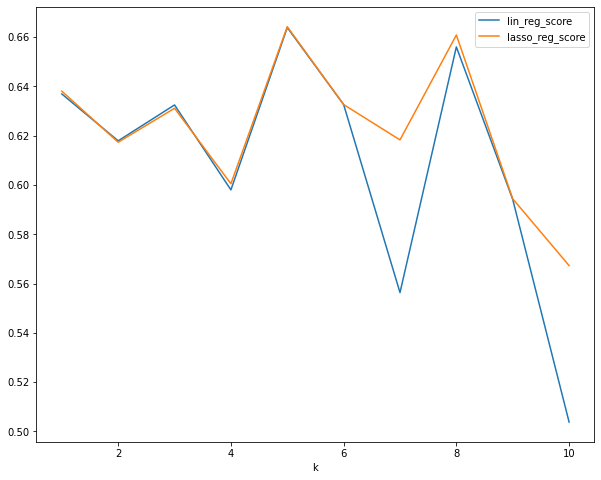

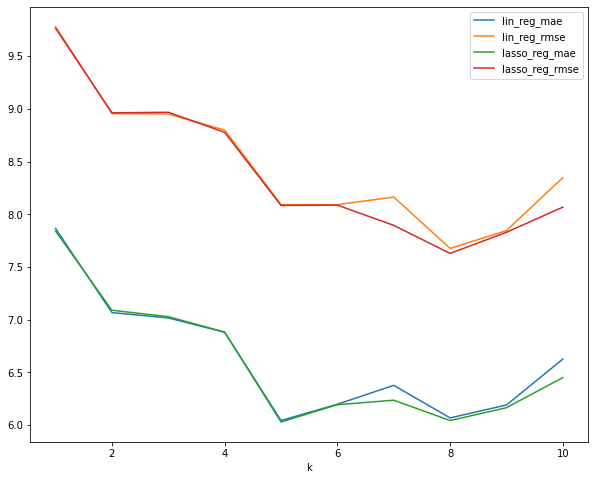

In [8]:
results_df.plot.line(x='k', y=['lin_reg_score', 'lasso_reg_score'], figsize=(10, 8))
results_df.plot.line(x='k', y=['lin_reg_mae', 'lin_reg_rmse', 'lasso_reg_mae', 'lasso_reg_rmse'], figsize=(10, 8))

## Modified version
Modifications:
1. Add standard scaler preprocessing
2. Add lasso regression to compare against linear regression
3. Re-run clustering & regression process with more random seeds

### Modification Part A - No preprocessing

In [18]:
results_dfs = [regression_on_locals_scores(random_state=r, scale=False) for r in np.arange(20)]
avg_results_df = pd.concat(results_dfs).groupby('k').mean()
avg_results_df

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.954e+01, tolerance: 1.378e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.954e+01, tolerance: 1.378e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.721e-01, tolerance: 1.716e-01

,lin_reg_score,lin_reg_mae,lin_reg_rmse,lin_reg_mape,lasso_reg_score,lasso_reg_mae,lasso_reg_rmse,lasso_reg_mape
k,,,,,,,,
1,0.584936,8.334555,10.498337,0.321378,0.584274,8.342749,10.507265,0.322683
2,0.542731,7.814131,10.049748,0.289557,0.543308,7.814302,10.044813,0.290260
3,0.571438,7.666142,9.869618,0.291135,0.571792,7.665629,9.868566,0.291393
4,0.564476,7.318666,9.432705,0.279801,0.565287,7.316208,9.424802,0.280018
5,0.605402,6.675993,8.600948,0.246512,0.607563,6.664640,8.584819,0.246799
6,0.522411,6.637230,8.605441,0.242387,0.591082,6.604669,8.558914,0.242357
7,0.558108,6.445757,8.318040,0.235930,0.615233,6.387869,8.202075,0.235302
8,0.452740,6.530621,8.394768,0.239476,0.576117,6.457496,8.248661,0.238654
9,0.444767,6.487201,8.317022,0.238277,0.573036,6.398064,8.163871,0.236832


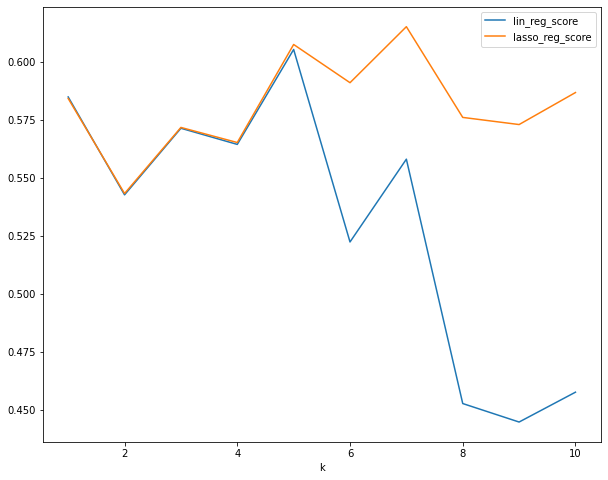

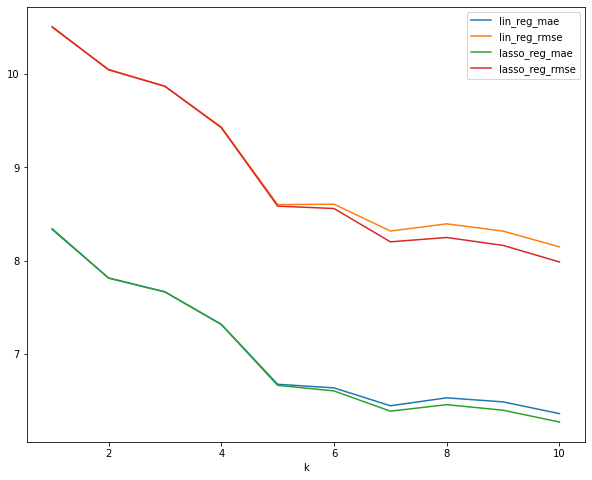

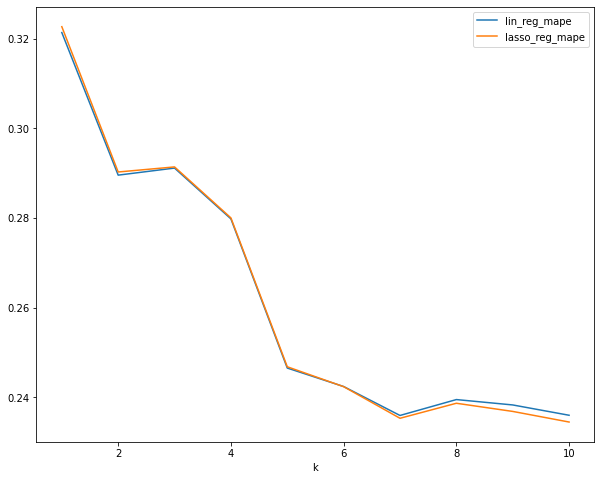

In [19]:
avg_results_df.plot.line(y=['lin_reg_score', 'lasso_reg_score'], figsize=(10, 8))
avg_results_df.plot.line(y=['lin_reg_mae', 'lin_reg_rmse', 'lasso_reg_mae', 'lasso_reg_rmse'], figsize=(10, 8))
avg_results_df.plot.line(y=['lin_reg_mape', 'lasso_reg_mape'], figsize=(10, 8))

When no preprocessing is applied, lasso regression has the same effect as linear regression for small numbers of k. But as k grows larger, lasso regression is better at yielding consistent results while linear regression degrades.

### Modification Part B - With preprocessing

In [11]:
results_dfs = [regression_on_locals_scores(random_state=r, scale=True) for r in np.arange(20)]
avg_results_scaled_df = pd.concat(results_dfs).groupby('k').mean()
avg_results_scaled_df

,lin_reg_score,lin_reg_mae,lin_reg_rmse,lin_reg_mape,lasso_reg_score,lasso_reg_mae,lasso_reg_rmse,lasso_reg_mape
k,,,,,,,,
1,5.849365e-01,8.334555e+00,1.049834e+01,3.213778e-01,0.547146,8.864061,10.973111,0.367006
2,6.698077e-01,7.302473e+00,9.218691e+00,2.779914e-01,0.640229,7.781691,9.664116,0.316386
3,6.277950e-01,7.063060e+00,8.938067e+00,2.661183e-01,0.558940,7.925846,9.763505,0.321162
4,6.049548e-01,7.036793e+00,8.762345e+00,2.636820e-01,0.550178,7.746439,9.450601,0.312553
5,6.519635e-01,6.148449e+00,7.801585e+00,2.181159e-01,0.558709,7.170134,8.887903,0.281950
6,6.530509e-01,6.126053e+00,7.754649e+00,2.190845e-01,0.543721,7.144380,8.993995,0.276257
7,-1.275153e+22,2.641950e+10,1.599952e+11,3.510647e+08,0.507185,7.207800,8.994070,0.282606
8,5.645743e-01,6.271849e+00,7.960268e+00,2.284728e-01,0.481115,7.262347,8.982225,0.286447
9,5.630009e-01,6.251213e+00,7.932799e+00,2.271147e-01,0.465983,7.252927,8.923673,0.286917


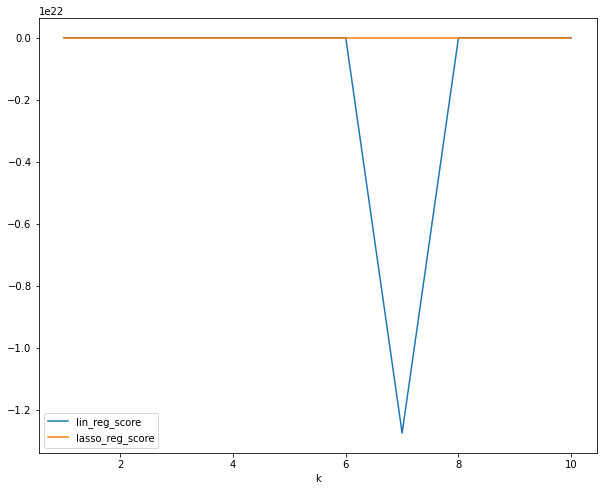

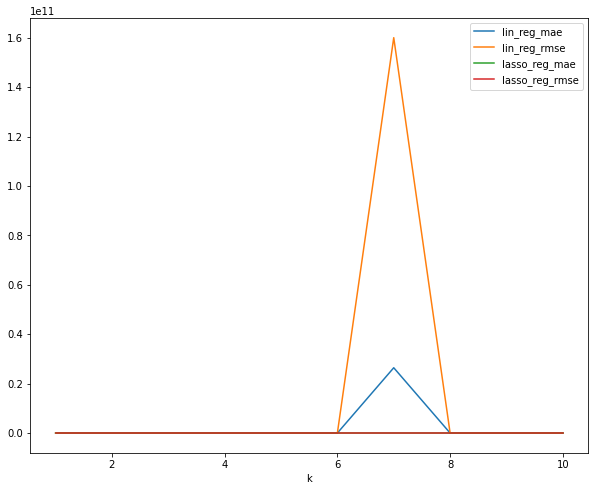

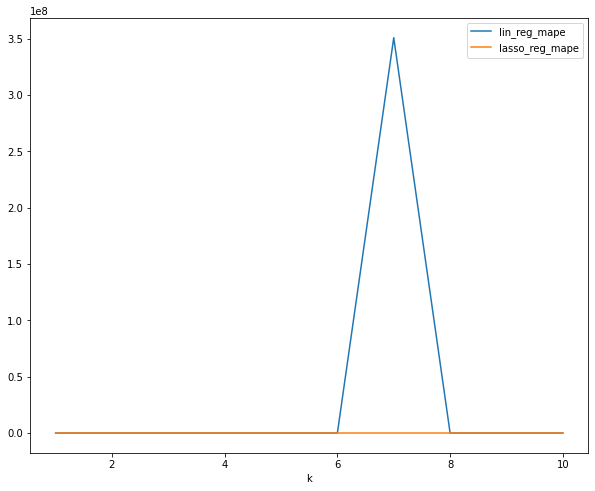

In [16]:
avg_results_df.plot.line(y=['lin_reg_score', 'lasso_reg_score'], figsize=(10, 8))
avg_results_df.plot.line(y=['lin_reg_mae', 'lin_reg_rmse', 'lasso_reg_mae', 'lasso_reg_rmse'], figsize=(10, 8))
avg_results_df.plot.line(y=['lin_reg_mape', 'lasso_reg_mape'], figsize=(10, 8))

The large spike is likely due to errors in the clustering which in turn leads to highly inaccurate linear regressions, which happens due to random chance. 

The plots are drawn again with the rows with outliers removed for easier viewing

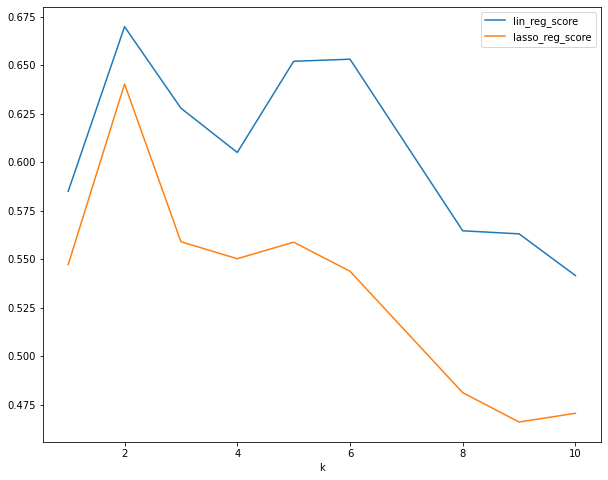

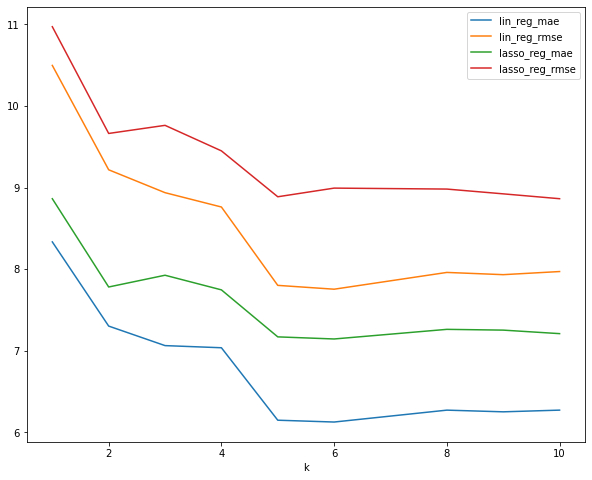

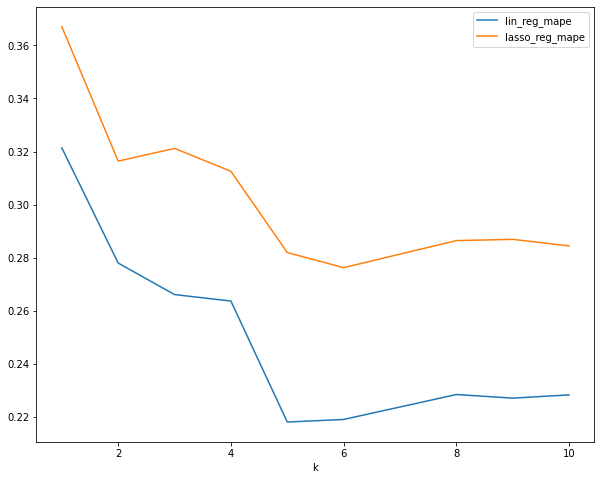

In [17]:
avg_results_no_outliers_df = avg_results_scaled_df[avg_results_scaled_df['lin_reg_score'] >= 0]

avg_results_no_outliers_df.plot.line(y=['lin_reg_score', 'lasso_reg_score'], figsize=(10, 8))
avg_results_no_outliers_df.plot.line(y=['lin_reg_mae', 'lin_reg_rmse', 'lasso_reg_mae', 'lasso_reg_rmse'], figsize=(10, 8))
avg_results_no_outliers_df.plot.line(y=['lin_reg_mape', 'lasso_reg_mape'], figsize=(10, 8))

It is surprising to observe that when standard scaling is applied, the lasso regression performs significantly worse than the plain linear regression.
* The linear regression score has improved with the addition of scaling
* The lasso regression score has slightly worsened with the addition of scaling
* The errors of lasso regression are significantly higher with scaling than without scaling

This suggests that standard scaling may positively affected the ordinary linear regression while adversely affecting the lasso regression. It is also possible that the KMeans clustering initial phase was adversely affected by the scaling.